# Project
## "Memory-based parameter adaptation"
*Pablo Sprechmann, Siddhant Jayakumar, Jack Rae, Alexander Pritzel, Adria Puigdomenech Badia, Benigno Uria, Oriol Vinyals, Demis Hassabis, Razvan Pascanu, Charles Blundell* <br><br>
https://openreview.net/pdf?id=rkfOvGbCW

Oskar Wieczorek (i263984)<br>

## About
In this project I tried to reproduce results presented in __Figure 3 [Left]__ (section 4.1, page 6) of the paper. I refined myself to comparing: __MLP__ to __MbPA__ with 250 examples and __MbPA__ with 100 examples. For this purpose I used simplified version of __MbPA__. The simplifications are listed below:<br>
* I didn't use regularization term $ \beta(\theta - \theta^x)$ as in __Equation 4__ (section 2.1, page 3).
* I used constant learning rate $\alpha = 0.1$ for MbPA training and not a grid search as described in section 4.1.
* I used constant number of MbPA steps $= 15$.

## Conclusions

### 1. My results roughly match with those presented in Figure 3 [Left] from the paper.
<div style="padding-right:34px"><img src='results_paper.png' width=500></div>
<h3><center>_Figure 3 [Left] from the paper_</center></h3>
<br>
<img src='results.png' width=530>
<h3><center>_Results obtained in this project (see "Results" section of this notebook)_</center></h3>

### 2. MbPA indeed mitigates the effects of catastrophic forgetting.

* Average improvement in accuracy of MbPA (Examples = 250) over MLP: __16.89%__ <br>
* Average improvement in accuracy of MbPA (Examples = 100) over MLP: __13.75%__ <br><br>
_(see the last cell of the "Results" section)_

### 3. Further points.

1. Which heuristic works best when the memory is limited?
2. What is the explanation of the regularization term in __Equation (4)__?
3. How many neighbours should be chosen to train the $g$-component?

## Source code

#### Imports 

In [1]:
%pylab inline

import os
import warnings
import copy

import torch
import numpy as np
import torchvision
import itertools as itt

from functools import partial

from torch.autograd import Variable
from numpy import argpartition as argprt

from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


#### Global settings

In [2]:
warnings.filterwarnings('ignore')

REPRODUCE_MY_RESULTS = True

if REPRODUCE_MY_RESULTS:
    torch.set_rng_state(torch.load('rng_state.txt'))

#### Helpers

In [3]:
def is_np(var):
    type(var).__module__ == 'numpy'
    
class tasks_generator:
    def __init__(self, data, n=Infinity):
        self.data = data
        self.i = 0
        self.n = n

    def __iter__(self):
        return self

    def next(self):
        if self.i < self.n:
            self.i += 1
            return self.data.index_select(1, torch.randperm(784))
        else:
            raise StopIteration()
            
def count_score(y_pred, y_true):
    if is_np(y_pred) and is_np(y_true):
        return (y_pred == y_true).sum()
    else:
        return torch.sum((y_pred == y_true).data)
    
def kNN(k, data, X):
    # returns :
    #   * array of indexes of k-nearest neighbours of X from data
    #   * squared distances
    dists = np.sum(X**2, 1).reshape(-1, 1) - 2 * X.dot(data.T) + np.sum(data**2, 1)
    idxs = argprt(dists, k)[:, :k]
    return (idxs, dists[np.arange(dists.shape[0]), idxs.T].T)

def mbpa_iter_info(task_size, task_n, i_task, i_x):
    return "Task #{0}. Testing ({1}/{2})...".format(task_n, (i_task-1) * task_size + i_x, task_n * task_size)

#### MLP

In [4]:
class MLPNetWrapper:
    def __init__(self, model, optimizer, loss_fun):
        self.model = model
        self.optimizer = optimizer
        self.loss_fun = loss_fun
        
    def train_on_task(self, task, y, epochs=20, minibatch_size=None, task_n=None):
        if minibatch_size:
            # mini-batch training
            task_size = task.size(0)
            total_batches = int(np.ceil(1.0 * task_size / minibatch_size))
            for ep in xrange(epochs):
                for mb in xrange(0, task_size, minibatch_size):
                    minibatch = task[mb:(mb + minibatch_size)]
                    if task_n: print("Task #{0}. Epoch ({1}/{2}). Mini-batch ({3}/{4})...       "
                              .format(task_n, ep + 1, epochs, mb / minibatch_size + 1, total_batches), end="\r")
                    y_pred = self.model(minibatch)
                    loss = self.loss_fun(y_pred, y[mb:(mb + minibatch_size)])
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
        else:
            for ep in xrange(epochs):
                # whole-batch training
                if task_n: print("Task #{0}. Epoch ({1}/{2}) ...".format(task_n, ep + 1, epochs), end="\r")
                y_pred = self.model(task)
                loss = self.loss_fun(y_pred, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            
    def predict(self, X):
        return torch.max(self.model(X), dim=1)[1]

#### Preparing MNIST dataset

In [5]:
task_size = 10000

_data = torchvision.datasets.MNIST(os.environ.get('PYTORCH_DATA_PATH', '../data'), train=True, download=True)

idxs = torch.randperm(_data.train_data.size()[0])[:task_size]
task_data = _data.train_data.index_select(0, idxs).view(-1, 784)
task_labels = _data.train_labels.index_select(0, idxs)
print(True)

True


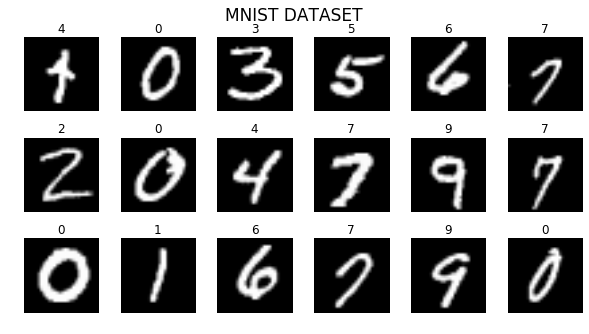

In [6]:
figsize(10, 5)
plt.suptitle('MNIST DATASET', fontsize=17); 
for i in range(3 * 6):
    subplot(3, 6, i + 1)
    plt.imshow(task_data[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(task_labels[i])
    plt.subplots_adjust(hspace=.3, wspace=.3)
plt.show()

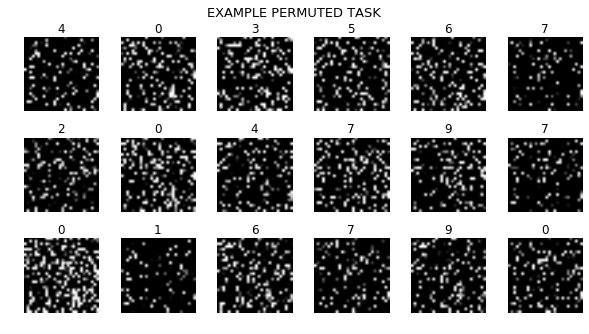

In [7]:
task_gen = tasks_generator(task_data)
ex_permuted_task = task_gen.next()

figsize(10, 5)
plt.suptitle('EXAMPLE PERMUTED TASK', fontsize=13); 
for i in range(3 * 6):
    subplot(3, 6, i + 1)
    plt.imshow(ex_permuted_task[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(task_labels[i])
    plt.subplots_adjust(hspace=.3, wspace=.3)
plt.show()

#### Catastrophic Forgetting visualized

Training...
Task #1. Done! Accuracy(1 → 1) = 88.57%                      
Task #2. Done! Accuracy(1 → 2) = 85.74%                      
Task #3. Done! Accuracy(1 → 3) = 82.44%                      
Task #4. Done! Accuracy(1 → 4) = 79.82%                      
Task #5. Done! Accuracy(1 → 5) = 76.82%                      
Task #6. Done! Accuracy(1 → 6) = 72.73%                      
Task #7. Done! Accuracy(1 → 7) = 72.33%                      
Task #8. Done! Accuracy(1 → 8) = 69.40%                      
Task #9. Done! Accuracy(1 → 9) = 67.42%                      
Task #10. Done! Accuracy(1 → 10) = 63.68%                      
Task #11. Done! Accuracy(1 → 11) = 62.86%                      
Task #12. Done! Accuracy(1 → 12) = 63.53%                      
Task #13. Done! Accuracy(1 → 13) = 62.08%                      
Task #14. Done! Accuracy(1 → 14) = 63.03%                      
Task #15. Done! Accuracy(1 → 15) = 61.20%                      
Task #16. Done! Accuracy(1 → 16) = 61.34%     

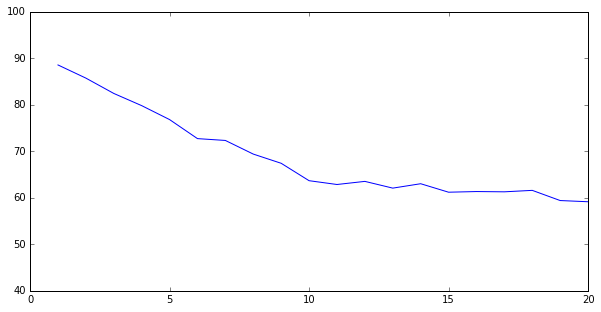

In [8]:
N, D_in, H, D_out = 50000, 784, 100, 10
learning_rate = 1e-4

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax()
)
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

y = Variable(task_labels, requires_grad=False)

MLPNet = MLPNetWrapper(model=model, optimizer=optimizer, loss_fun=loss_fn)

tasks = []
scores = []

n_epochs = 3
n_tasks = 20
minibatch_size = 100

print('Training...')
for task_n in xrange(1, n_tasks + 1):
    x = Variable(task_gen.next().type(torch.FloatTensor), requires_grad=False)
    tasks.append(x)
    
    MLPNet.train_on_task(x, y, epochs=n_epochs, minibatch_size=minibatch_size, task_n=task_n)
    print("Task #{0}. Computing accuracy ...".format(task_n), end="\r")
    total_score = 0
    for past_task in tasks:
        total_score += count_score(MLPNet.predict(past_task), y)
    
    total_score = total_score / (1.0 * task_n * task_size)
    
    scores.append(total_score)
    print("Task #{0}. Done! Accuracy(1 → {1}) = {2:.2f}%                      "
          .format(task_n, task_n, 100 * total_score))

plt.plot(np.arange(1, 21), 100 * np.array(scores))
plt.ylim(0, 20)
plt.ylim(40, 100)
plt.xticks(range(0, 21, 5))
plt.show()

#### MbPA

In [9]:
class Memory:
    def __init__(self, orient='h', limit=Inf):
        self.data = []
        self.data_joined = None
        self.size = 0
        self.limit = limit
        self.pending = False
        self.orientation = orient # horizontal or vertical, 'h' or 'v'
    
    def add(self, new_data):
        self.data.append(new_data)
        self.size += new_data.shape[0]
        self.pending = True
        
    def joined(self):
        if self.pending:
            self.data_joined = (np.vstack(self.data) if self.orientation == 'v' else np.hstack(self.data))
            self.pending = False
        return self.data_joined

In [10]:
class MbPANetWrapper:
    def __init__(self, f_net, g_net, mem_limit, optimizer_train, optimizer_g, loss_fun, n_examples=100):
        self.f_net = f_net
        self.g_net = g_net
        self.MEMORY_HS = Memory('v', mem_limit)
        self.MEMORY_YS = Memory('h', mem_limit)
        self.optimizer_train = optimizer_train
        self.optimizer_g = optimizer_g
        self.loss_fun = loss_fun
        self.n_examples = n_examples
        
    def train_on_task(self, task, y, iters=10):
        for i in xrange(iters):
            # picking mini-batch
            task_size = task.size(0)
            minibatch_idxs = Variable(torch.randperm(task_size)[:self.n_examples], requires_grad=False)
            minibatch = task.index_select(0, minibatch_idxs)
            y_minibatch = y.index_select(0, minibatch_idxs) # classes for minibatch

            y_pred_f = self.f_net(minibatch) 
            
            # memory update
            self.MEMORY_HS.add(y_pred_f.data.numpy())
            self.MEMORY_YS.add(y_minibatch.data.numpy())
            
            # training (g+f) components
            loss = self.loss_fun(self.g_net(y_pred_f), y_minibatch)
            self.optimizer_train.zero_grad()
            loss.backward()
            self.optimizer_train.step()
    
    def predict_raw(self, X): 
        return torch.max(self.g_net(self.f_net(X)), dim=1)[1]
    
    def predict(self, X, K=20, mbpa_iters=15, iter_info=None):
        # retrieving context
        q = self.f_net(X).data.numpy()
        idxs, dists = kNN(K, self.MEMORY_HS.joined(), q)
        
        results = []
        
        # iteration over all x's in X
        for i in xrange(X.size(0)):
            ctx_h = Variable(torch.from_numpy(self.MEMORY_HS.joined()[idxs[i]]))
            ctx_v = Variable(torch.from_numpy(self.MEMORY_YS.joined()[idxs[i]]).unsqueeze(1))
            ctx_w = Variable(torch.from_numpy(1 / (dists[i] + 1e-10)))
            
            print((iter_info(i+1) if iter_info else "{0}/{1}".format(i + 1, X.size(0))).ljust(40), end="\r")
            
            # copy of the g-component, discarded afterwards
            g_net_copy = copy.deepcopy(self.g_net)
            mbpa_optim = type(self.optimizer_g)(g_net_copy.parameters(), 
                                                lr=self.optimizer_g.param_groups[0]['lr'])
            # local MbPA adaptation
            for _ in xrange(mbpa_iters):
                ctx_preds = g_net_copy(ctx_h)
                loss = -(ctx_preds.gather(1, ctx_v).squeeze(1)).sum()
                mbpa_optim.zero_grad()
                loss.backward()
                mbpa_optim.step()
            
            results.append(torch.max(g_net_copy(self.f_net(X[i])), dim=0)[1])
        return torch.cat(results)

## Testing MbPA

#### Test settings

In [11]:
n_tasks = 20
test_size = 250

task_gen = tasks_generator(task_data)
tasks = []

scores_mbpa250 = []
scores_mbpa100 = []
scores_raw = []

### MbPA (Examples = 250)

#### Hyperparameters and network architecture

In [12]:
N, D_in, H, D_out = 50000, 784, 200, 10
D_key = 200 # must be big enough

learning_rate = 1e-4
learning_rate_mbpa = 0.1

f_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_key)
)

g_net = torch.nn.Sequential(
    torch.nn.Linear(D_key, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax()
)

optimizer_train = torch.optim.Adam(itt.chain(f_net.parameters(), g_net.parameters()), lr=learning_rate)
optimizer_g = torch.optim.Adam(g_net.parameters(), lr=learning_rate_mbpa)

loss_fun = torch.nn.CrossEntropyLoss(size_average=False) # loss function used during training

n_examples = 250
n_iters = 100

#### Testing loop

In [13]:
MbPA = MbPANetWrapper(f_net, g_net, mem_limit=Inf, optimizer_train=optimizer_train, optimizer_g=optimizer_g, 
                      loss_fun=loss_fun, n_examples=n_examples)

print('MbPA (Examples = {0})'.format(n_examples))
for i_task in xrange(1, n_tasks + 1):
    x = Variable(task_gen.next().type(torch.FloatTensor), requires_grad=False)
    tasks.append(x)

    print("Task #{0}. Training ...".format(i_task), end="\r")
    MbPA.train_on_task(x[test_size:], y[test_size:], iters=n_iters)
    
    total_score_mbpa250 = 0
    total_score_raw = 0

    for i_test, past_task in enumerate(tasks):
        total_score_raw += count_score(MbPA.predict_raw(past_task[:test_size]), y[:test_size])
        total_score_mbpa250 += count_score(MbPA.predict(past_task[:test_size], 
                iter_info=partial(mbpa_iter_info, test_size, i_task, i_test + 1)), y[:test_size])
    
    total_score_mbpa250 = total_score_mbpa250 / (1.0 * i_task * test_size)
    total_score_raw = total_score_raw / (1.0 * i_task * test_size)
    
    scores_mbpa250.append(total_score_mbpa250)
    scores_raw.append(total_score_raw)
    print("Task #{0}. Done! Accuracy(1 → {1}) = {2:.2f}% (MbPA{3}), {4:.2f}% (MLP)                    "
            .format(i_task, i_task, 100 * total_score_mbpa250, n_examples, 100 * total_score_raw))

MbPA (Examples = 250)
Task #1. Done! Accuracy(1 → 1) = 89.20% (MbPA250), 86.00% (MLP)                    
Task #2. Done! Accuracy(1 → 2) = 91.40% (MbPA250), 83.60% (MLP)                    
Task #3. Done! Accuracy(1 → 3) = 89.60% (MbPA250), 83.47% (MLP)                    
Task #4. Done! Accuracy(1 → 4) = 87.90% (MbPA250), 81.40% (MLP)                    
Task #5. Done! Accuracy(1 → 5) = 88.08% (MbPA250), 78.48% (MLP)                    
Task #6. Done! Accuracy(1 → 6) = 87.93% (MbPA250), 72.20% (MLP)                    
Task #7. Done! Accuracy(1 → 7) = 86.74% (MbPA250), 72.86% (MLP)                    
Task #8. Done! Accuracy(1 → 8) = 87.10% (MbPA250), 70.20% (MLP)                    
Task #9. Done! Accuracy(1 → 9) = 85.73% (MbPA250), 62.71% (MLP)                    
Task #10. Done! Accuracy(1 → 10) = 85.00% (MbPA250), 60.84% (MLP)                    
Task #11. Done! Accuracy(1 → 11) = 85.05% (MbPA250), 63.05% (MLP)                    
Task #12. Done! Accuracy(1 → 12) = 84.50% (MbPA250

### MbPA (Examples = 100)

#### Hyperparameters and network architecture

In [14]:
N, D_in, H, D_out = 50000, 784, 200, 10
D_key = 200 # must be big enough

learning_rate = 1e-4
learning_rate_mbpa = 0.1

f_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_key)
)

g_net = torch.nn.Sequential(
    torch.nn.Linear(D_key, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax()
)

optimizer_train = torch.optim.Adam(itt.chain(f_net.parameters(), g_net.parameters()), lr=learning_rate)
optimizer_g = torch.optim.Adam(g_net.parameters(), lr=learning_rate_mbpa)

loss_fun = torch.nn.CrossEntropyLoss(size_average=False) # loss function used during training

n_examples = 100
n_iters = 250

#### Testing loop

In [15]:
MbPA = MbPANetWrapper(f_net, g_net, mem_limit=Inf, optimizer_train=optimizer_train, optimizer_g=optimizer_g, 
                      loss_fun=loss_fun, n_examples=n_examples)

print('MbPA (Examples = {0})'.format(n_examples))
for i_task in xrange(1, n_tasks + 1):
    x = tasks[i_task - 1]

    print("Task #{0}. Training ...".format(i_task), end="\r")
    MbPA.train_on_task(x[test_size:], y[test_size:], iters=n_iters)
    
    total_score_mbpa100 = 0

    for i_test, past_task in enumerate(tasks[:i_task]):
        total_score_mbpa100 += count_score(MbPA.predict(past_task[:test_size], 
                iter_info=partial(mbpa_iter_info, test_size, i_task, i_test + 1)), y[:test_size])
    
    total_score_mbpa100 = total_score_mbpa100 / (1.0 * i_task * test_size)
    
    scores_mbpa100.append(total_score_mbpa100)
    print("Task #{0}. Done! Accuracy(1 → {1}) = {2:.2f}% (MbPA{3})                       "
            .format(i_task, i_task, 100 * total_score_mbpa100, n_examples, 100 * total_score_raw))

MbPA (Examples = 100)
Task #1. Done! Accuracy(1 → 1) = 90.40% (MbPA100)                       
Task #2. Done! Accuracy(1 → 2) = 90.00% (MbPA100)                       
Task #3. Done! Accuracy(1 → 3) = 90.53% (MbPA100)                       
Task #4. Done! Accuracy(1 → 4) = 90.30% (MbPA100)                       
Task #5. Done! Accuracy(1 → 5) = 90.16% (MbPA100)                       
Task #6. Done! Accuracy(1 → 6) = 87.80% (MbPA100)                       
Task #7. Done! Accuracy(1 → 7) = 87.09% (MbPA100)                       
Task #8. Done! Accuracy(1 → 8) = 85.00% (MbPA100)                       
Task #9. Done! Accuracy(1 → 9) = 83.42% (MbPA100)                       
Task #10. Done! Accuracy(1 → 10) = 79.44% (MbPA100)                       
Task #11. Done! Accuracy(1 → 11) = 77.85% (MbPA100)                       
Task #12. Done! Accuracy(1 → 12) = 76.07% (MbPA100)                       
Task #13. Done! Accuracy(1 → 13) = 76.00% (MbPA100)                       
Task #14. Done! Accur

## Results

In [19]:
scores_mbpa250 = np.array(scores_mbpa250)
scores_mbpa100 = np.array(scores_mbpa100)
scores_raw = np.array(scores_raw)

np.save('scores_mbpa250', scores_mbpa250)
np.save('scores_mbpa100', scores_mbpa100)
np.save('scores_raw', scores_raw)

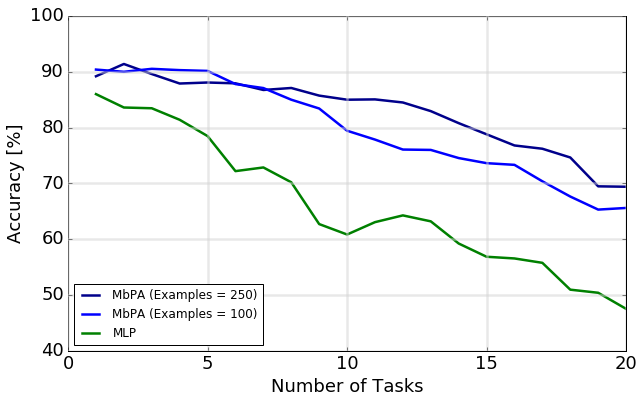

In [107]:
figsize(10, 6)
scores_mbpa250 = np.load('scores_mbpa250.npy')
scores_mbpa100 = np.load('scores_mbpa100.npy')
scores_raw = np.load('scores_raw.npy')

plt.plot(np.arange(1, n_tasks + 1), 100 * scores_mbpa250, label='MbPA (Examples = 250)', 
         c='darkblue', linewidth=2.5)
plt.plot(np.arange(1, n_tasks + 1), 100 * scores_mbpa100, label='MbPA (Examples = 100)', 
         c='b', linewidth=2.5)
plt.plot(np.arange(1, n_tasks + 1), 100 * scores_raw, label='MLP',
         c='green', linewidth=2.5)
plt.xlim(0, n_tasks)
plt.ylim(40, 100)
plt.grid(c='lightgray', linestyle='-', linewidth=2.5, alpha=0.5)
plt.xticks(range(0, n_tasks + 1, 5), size=18)
plt.yticks(range(40, 101, 10), size=18)
plt.legend(loc='lower left')
plt.xlabel('Number of Tasks', size=18)
plt.ylabel('Accuracy [%]', size=18)
plt.savefig('results')
plt.show()

In [3]:
print("Average improvement in accuracy of MbPA (Examples = 250) over MLP:\n{0:.2f}%\n"
      .format(100 * np.mean(scores_mbpa250 - scores_raw)))
print("Average improvement in accuracy of MbPA (Examples = 100) over MLP:\n{0:.2f}%"
      .format(100 * np.mean(scores_mbpa100 - scores_raw)))

Average improvement in accuracy of MbPA (Examples = 250) over MLP:
16.89%

Average improvement in accuracy of MbPA (Examples = 100) over MLP:
13.75%
